In [1]:
import argparse
import cvxpy as cp
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

In [2]:
def get_rand_mean_sigma(d):
    mu        = np.random.rand(d)
    sigma_tmp = np.random.rand(d, d)
    sigma     = np.dot(sigma_tmp, sigma_tmp.transpose())
    return mu, sigma

In [3]:
# distribution parameters need to be fixed for the simulation
mu_G, sigma_G = get_rand_mean_sigma(5)
mu_L, sigma_L = get_rand_mean_sigma(5)
mu_N, sigma_N = get_rand_mean_sigma(5)

# constants to match form of https://www.sciencedirect.com/science/article/pii/S1877705814011771?ref=pdf_download&fr=RR-2&rr=875e3f6f1afa2b0b
# but not strictly necessary for dynamics generation
g       = 1
U_0     = 1
theta_0 = 0

In [4]:
def generate_data(num_samples):
    G = np.random.multivariate_normal(mu_G, sigma_G, num_samples)
    L = np.random.multivariate_normal(mu_L, sigma_L, num_samples)
    N = np.random.multivariate_normal(mu_N, sigma_N, num_samples)
    
    final_row = np.ones((G.shape[0], 4))
    final_row[:,0] = final_row[:,3] = 0
    final_row[:,2] = np.tan(theta_0)

    xs = np.hstack([G, L, N])
    As = np.transpose(np.array([
        np.hstack([G[:,:3], np.ones((G.shape[0],1)) * (g * np.cos(theta_0))]) / U_0,
        np.hstack([L[:,:3], np.zeros((L.shape[0],1))]),
        np.hstack([N[:,:3], np.zeros((N.shape[0],1))]),
        final_row,
    ]), (1,0,2))

    Bs = np.transpose(np.array([
        G[:,3:] / U_0,
        L[:,3:],
        N[:,3:],
        np.zeros((G.shape[0], 2)),
    ]), (1,0,2))

    xs = torch.from_numpy(xs).to(torch.float32)
    As = torch.from_numpy(As).to(torch.float32)
    Bs = torch.from_numpy(Bs).to(torch.float32)

    return xs, (As, Bs)

In [5]:
N_train = 800
xs_train, (As_train, Bs_train) = generate_data(num_samples=N_train)

In [6]:
class ContextualLQR(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        
        self.fc_A = nn.Linear(64, 16)
        self.fc_B = nn.Linear(64, 8)
        
        # self.conv_A = nn.Conv2d(1, 1, 3, padding="same")
        # self.conv_B = nn.Conv2d(1, 1, 3, padding="same")

    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        fc2_x = self.fc2(x)
        x     = F.relu(x + fc2_x)

        fc3_x = self.fc3(x)
        x     = F.relu(x + fc3_x)

        # for predictions of A matrix
        A = self.fc_A(x).reshape((-1,4,4))
        # A    = self.conv_A(fc_A)

        # for predictions of B matrix
        B = self.fc_B(x).reshape((-1,4,2))
        # B    = self.conv_B(fc_B)

        return A, B

In [7]:
import torch.optim as optim

net       = ContextualLQR()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

In [8]:
batch_size = 10
num_batches = N_train // batch_size
losses = []
for epoch in range(50):  # loop over the dataset multiple times
    rolling_loss = 0
    for i in range(num_batches):
        x_batch, A_batch, B_batch = xs_train[i*batch_size:(i+1)*batch_size], As_train[i*batch_size:(i+1)*batch_size], Bs_train[i*batch_size:(i+1)*batch_size]
        optimizer.zero_grad()

        A_hat_batch, B_hat_batch = net(x_batch)
        loss = criterion(A_hat_batch, A_batch) + criterion(B_hat_batch, B_batch)
        loss.backward()
        optimizer.step()

        rolling_loss += loss.item()
    losses.append(rolling_loss)
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {rolling_loss}')
print('Finished Training')

[1,    80] loss: 84.2715722322464
[2,    80] loss: 20.747319042682648
[3,    80] loss: 10.27705280482769
[4,    80] loss: 5.83931452780962
[5,    80] loss: 4.083227468654513
[6,    80] loss: 3.206964725628495
[7,    80] loss: 2.677699137479067
[8,    80] loss: 2.3191924802958965
[9,    80] loss: 2.056959195062518
[10,    80] loss: 1.8532839734107256
[11,    80] loss: 1.6896447157487273
[12,    80] loss: 1.5514149880036712
[13,    80] loss: 1.4323559291660786
[14,    80] loss: 1.3273079553619027
[15,    80] loss: 1.2313386127352715
[16,    80] loss: 1.1462378157302737
[17,    80] loss: 1.069804571568966
[18,    80] loss: 0.9994597779586911
[19,    80] loss: 0.9289271789602935
[20,    80] loss: 0.8671752926893532
[21,    80] loss: 0.8132944344542921
[22,    80] loss: 0.7669160049408674
[23,    80] loss: 0.723790024407208
[24,    80] loss: 0.6897692172788084
[25,    80] loss: 0.6566226184368134
[26,    80] loss: 0.6262220568023622
[27,    80] loss: 0.5997364199720323
[28,    80] loss: 0.5

<Axes: >

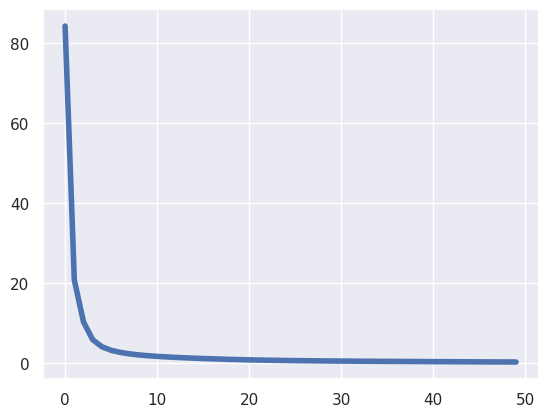

In [9]:
import seaborn as sns
sns.set_theme()
sns.lineplot(x=range(len(losses)), y=losses, lw=4)

In [10]:
def generate_scores(net, num_samples):
    xs, (As, Bs) = generate_data(num_samples=num_samples)
    A_hat, B_hat = net(xs)
    C = torch.cat([As, Bs], axis=-1).cpu().detach().numpy()
    C_hat = torch.cat([A_hat, B_hat], axis=-1).cpu().detach().numpy()
    diff = C - C_hat
    return (C, C_hat), np.linalg.norm(diff, ord=2, axis=(1,2))

In [11]:
N_cal, N_test = 200, 200
(cal_C, cal_C_hat),   cal_scores  = generate_scores(net, num_samples=N_cal)
(test_C, test_C_hat), test_scores = generate_scores(net, num_samples=N_test)

In [12]:
alpha = 0.05
q_hat = np.quantile(cal_scores, q = 1-alpha)
coverage = np.sum(test_scores < q_hat) / N_test
print(f"Coverage: {coverage}")

Coverage: 0.95


In [14]:
with open("experiments/airfoil.pkl", "wb") as f:
    pickle.dump({
        "test_C": test_C, 
        "test_C_hat": test_C_hat,
        "q_hat": q_hat,
    }, f)